In [1]:
!pip install datasets seacrowd

In [2]:
from datasets import load_dataset
from torch.utils.data import DataLoader, RandomSampler, BatchSampler

# Load the 'google/fleurs' dataset for 'hi_in' (Hindi - India)
dset = load_dataset("SEACrowd/indo_general_mt_en_id", trust_remote_code=True)


/home/fachri/nusax/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Split the dataset into training, validation, and test sets
train_data = dset['train']
val_data = dset['validation']
test_data = dset['test']

In [4]:
train_data

Dataset({
    features: ['id', 'src', 'tgt'],
    num_rows: 1821716
})

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

# Extract source (Indonesian) and target (English) texts from each split
train_source_texts = [example['src'] for example in train_data][:100000]
train_target_texts = [example['tgt'] for example in train_data][:100000]

val_source_texts = [example['src'] for example in val_data]
val_target_texts = [example['tgt'] for example in val_data]

test_source_texts = [example['src'] for example in test_data]
test_target_texts = [example['tgt'] for example in test_data]

2024-11-04 07:05:36.642732: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 07:05:36.664641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 07:05:36.664661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 07:05:36.665513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 07:05:36.669621: I tensorflow/core/platform/cpu_feature_guar

In [6]:
# Add <SOS> and <EOS> tokens to target sentences
train_target_texts = ["<sos> " + sentence + " <eos>" for sentence in train_target_texts]
val_target_texts = ["<sos> " + sentence + " <eos>" for sentence in val_target_texts]
test_target_texts = ["<sos> " + sentence + " <eos>" for sentence in test_target_texts]

In [7]:
train_source_texts

['Mr. Tanaka is not a student.',
 'My father is a teacher.',
 'There is no school.',
 'It was sunny in Tokyo.',
 'There is a tree in the park.',
 'Where is Mr. Tanaka?',
 'I do not have any money.',
 'There is a book on the desk.',
 'There is a bag under the desk.',
 'There is a notebook in the bag.',
 'Mr. Yamada is to the right of Mr. Tanaka.',
 'Ms. Kimura is to the left of Mr. Tanaka.',
 'There is a cat in front of the house.',
 'There is a car behind the house.',
 'The postbox is across the street from our house.',
 'Mr. Yamada is outside the classroom.',
 'There is a park in front of the house.',
 'The school is near the house.',
 'The book is in the bag.',
 'This is my pen.',
 'Where is the Japanese classroom?',
 'When is that newspaper from?',
 'There is a new computer in the classroom.',
 'There is a small dog in the box.',
 'Mr. Tanaka is an energetic person.',
 'What kind of film is it?',
 "It's an old Japanese film.",
 'Which shoes are you going to buy?',
 'That is the Japa

In [8]:
import tensorflow as tf
print(tf.sysconfig.get_build_info()['cuda_version'])
print(tf.sysconfig.get_build_info()['cudnn_version'])
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

12.2
8
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


2024-11-04 07:06:13.215027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-04 07:06:13.215812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-04 07:06:13.215921: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/usr/lib/llvm-17/bin/clang'),
             ('cuda_compute_capabilities',
              ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '12.2'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [10]:
print(tf.__version__)

2.15.0


In [11]:
# Tokenization (Source and Target)
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

source_tokenizer.fit_on_texts(train_source_texts)
target_tokenizer.fit_on_texts(train_target_texts)

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Convert texts to sequences
train_source_sequences = source_tokenizer.texts_to_sequences(train_source_texts)
train_target_sequences = target_tokenizer.texts_to_sequences(train_target_texts)

val_source_sequences = source_tokenizer.texts_to_sequences(val_source_texts)
val_target_sequences = target_tokenizer.texts_to_sequences(val_target_texts)

test_source_sequences = source_tokenizer.texts_to_sequences(test_source_texts)
test_target_sequences = target_tokenizer.texts_to_sequences(test_target_texts)

In [12]:
print(len(train_target_sequences[1]))
print(len(val_target_sequences[0]))

5
24


In [13]:
# Pad sequences to ensure uniform input size
max_source_length = 60#max(len(seq) for seq in train_source_sequences)
max_target_length = 60#max(len(seq) for seq in train_source_sequences)  #to include EOS or shifted tokens
X_train_source = pad_sequences(train_source_sequences, maxlen=max_source_length, padding='post')
X_train_target = pad_sequences(train_target_sequences, maxlen=max_target_length, padding='post')

X_val_source = pad_sequences(val_source_sequences, maxlen=max_source_length, padding='post')
X_val_target = pad_sequences(val_target_sequences, maxlen=max_target_length, padding='post')

X_test_source = pad_sequences(test_source_sequences, maxlen=max_source_length, padding='post')
X_test_target  = pad_sequences(test_target_sequences, maxlen=max_target_length, padding='post')


In [14]:
X_train_target.shape

(100000, 60)

In [15]:
# # Prepare target sequences for teacher forcing (shifted by one position)
# y_train = X_train_target_padded[:, 1:]  # Shape: (num_samples, sequence_length - 1)
# y_val = X_val_target_padded[:, 1:]
# y_test = X_test_target_padded[:, 1:]  # Shape: (num_samples, sequence_length - 1)
# # Decoder input sequences (without the last token)
# X_train_target = X_train_target_padded[:, :-1]  # Remove the last token for input
# X_val_target = X_val_target_padded[:, :-1]
# X_test_target = X_test_target_padded[:, :-1]  # Remove the last token for input

In [16]:
# Shift target sequences for teacher forcing
y_train = X_train_target[:, 1:]
X_train_target = X_train_target[:, :-1]

y_val = X_val_target[:, 1:]
X_val_target = X_val_target[:, :-1]

y_test = X_test_target[:, 1:]
X_test_target = X_test_target[:, :-1]


In [17]:
# Check dimensions
print(f'X_train_source shape: {X_train_source.shape}')
print(f'X_val_source shape: {X_val_source.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train_source shape: (100000, 60)
X_val_source shape: (2000, 60)
y_train shape: (100000, 59)
y_val shape: (2000, 59)


In [18]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Model

# Hyperparameters
EMBEDDING_SIZE = 256       # Size of the embedding layer
RNN_UNITS = 256            # Number of RNN units

# Encoder Model
encoder_inputs = Input(shape=(max_source_length,))
encoder_embedding_layer = Embedding(source_vocab_size, EMBEDDING_SIZE)(encoder_inputs)
encoder = SimpleRNN(RNN_UNITS, return_state=True)
encoder_outputs, h = encoder(encoder_embedding_layer)
encoder_states = h

# Decoder Model
decoder_inputs = Input(shape=(1,))  # Input shape for a single time step
decoder_embedding_layer = Embedding(target_vocab_size, EMBEDDING_SIZE)(decoder_inputs)
decoder = SimpleRNN(RNN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder(decoder_embedding_layer, initial_state=encoder_states)

# Output Layer
output_dense_layer = Dense(target_vocab_size, activation='softmax')
outputs = output_dense_layer(decoder_outputs)

# Complete Seq2Seq Model
model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


2024-11-04 07:06:16.245028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-04 07:06:16.245209: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-04 07:06:16.245347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 256)              2065920   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 256)               2032614   ['input_2[0][0]']         

In [20]:
print(decoder_outputs.shape)
print(outputs.shape)

(None, 1, 256)
(None, 1, 79399)


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Add model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    'mt_best_val_accuracy_{val_accuracy:.4f}.keras',  # File path to save the model
    monitor='val_accuracy',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='max',  # Minimize validation loss
    verbose=1  # Print a message when the model is saved
)

In [22]:
# Fit the model with the ModelCheckpoint callback
history = model.fit([X_train_source, X_train_target], y_train,
                    epochs=5, batch_size=32,
                    validation_data=([X_val_source, X_val_target], y_val),
                    callbacks=[model_checkpoint])

Epoch 1/5


2024-11-04 07:06:17.383936: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f03ac0c7b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-04 07:06:17.383953: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-04 07:06:17.387292: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-04 07:06:17.419495: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1730678777.463734   68147 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2898/3125 [==========================>...] - ETA: 32s - loss: 1.9330 - accuracy: 0.7679

KeyboardInterrupt: 

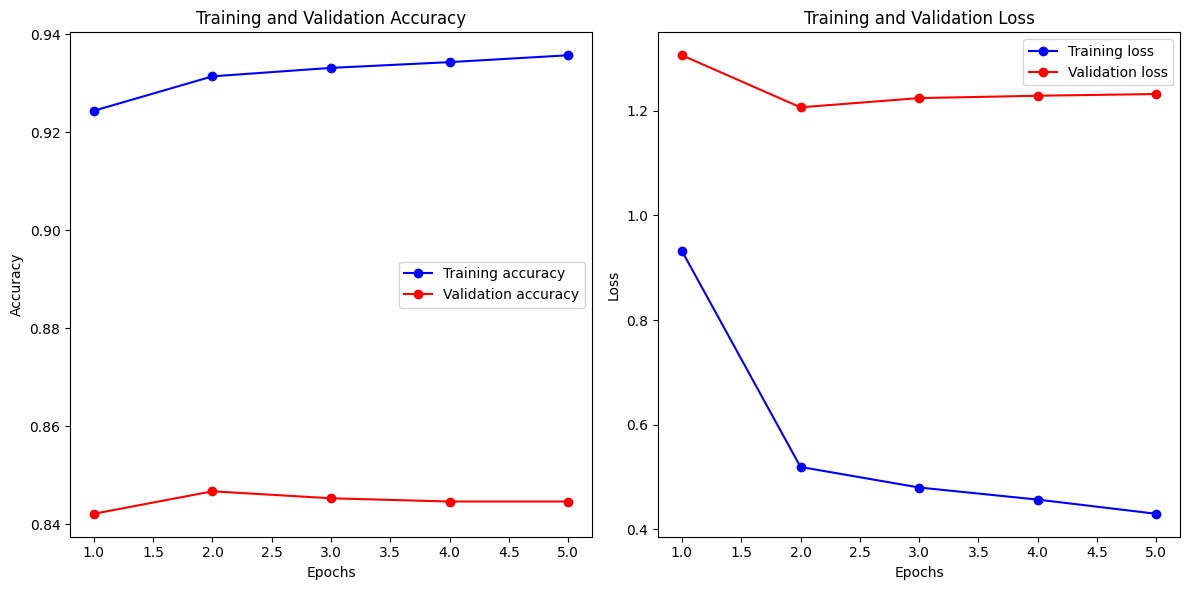

In [65]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss from the history object
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [66]:
!pip install nltk

In [2]:
from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

dset = load_dataset("SEACrowd/indo_general_mt_en_id", trust_remote_code=True)
# Split the dataset into training, validation, and test sets
train_data = dset['train']
val_data = dset['validation']
# Extract source (Indonesian) and target (English) texts from each split
train_source_texts = [example['src'] for example in train_data][:10000]
train_target_texts = [example['tgt'] for example in train_data][:10000]

val_source_texts = [example['src'] for example in val_data]
val_target_texts = [example['tgt'] for example in val_data]

# Tokenization (Source and Target)
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

source_tokenizer.fit_on_texts(train_source_texts)
target_tokenizer.fit_on_texts(train_target_texts)
val_source_sequences = source_tokenizer.texts_to_sequences(val_source_texts)
val_target_sequences = target_tokenizer.texts_to_sequences(val_target_texts)


In [4]:

import numpy as np
# Pad sequences to ensure uniform input size
max_source_length = 60#max(len(seq) for seq in train_source_sequences)
max_target_length = 60#max(len(seq) for seq in train_source_sequences)  #to include EOS or shifted tokens
X_val_source = pad_sequences(val_source_sequences, maxlen=max_source_length, padding='post')
X_val_target  = pad_sequences(val_target_sequences, maxlen=max_target_length, padding='post')
y_val = np.zeros_like(X_val_target)
y_val[:, :-1] = X_val_target[:, 1:]

In [5]:
test_data = dset['test']

test_source_texts = [example['src'] for example in test_data]
test_target_texts = [example['tgt'] for example in test_data]

test_source_sequences = source_tokenizer.texts_to_sequences(test_source_texts)
test_target_sequences = target_tokenizer.texts_to_sequences(test_target_texts)


# Pad sequences to ensure uniform input size
# max_source_length = 60#max(len(seq) for seq in train_source_sequences)
# max_target_length = 60#max(len(seq) for seq in train_source_sequences)  #to include EOS or shifted tokens
X_test_source = pad_sequences(test_source_sequences, maxlen=max_source_length, padding='post')
X_test_target  = pad_sequences(test_target_sequences, maxlen=max_target_length, padding='post')

y_test = np.zeros_like(X_test_target)
y_test[:, :-1] = X_test_target[:, 1:]

In [32]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction, sentence_bleu


# Load the trained model
model = load_model('mt_best_val_accuracy_hehe_0.7164.keras')

# Generate predictions
predicted_probabilities = model.predict([X_val_source[:100], X_val_target[:100]])
predicted_sequences = np.argmax(predicted_probabilities, axis=-1)

# Convert predictions and references to lists of sentences
predicted_sentences = []
reference_sentences = []

for i in range(len(predicted_sequences)):
    predicted_sent = predicted_sequences[i]
    reference_sent = X_val_target[i]

    # Remove padding (assuming padding is done with a specific token, e.g., 0)
    predicted_sent = [word for word in predicted_sent if word != 0]
    reference_sent = [word for word in reference_sent if word != 0]

    predicted_sentences.append(predicted_sent)
    reference_sentences.append([reference_sent])  # NLTK expects a list of references

# Calculate BLEU score
bleu_score = corpus_bleu(reference_sentences, predicted_sentences, smoothing_function=SmoothingFunction().method1)
print(f'BLEU Score: {bleu_score:.4f}')


ValueError: in user code:

    File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_25" is incompatible with the layer: expected shape=(None, 77), found shape=(None, 60)


In [36]:
# # Evaluation on the test set
# test_target_sequences_shifted = np.zeros_like(X_test_target)
# test_target_sequences_shifted[:, :-1] = X_test_target[:, 1:]
# y_test = to_categorical(test_target_sequences_shifted, num_classes=target_vocab_size)
# test_loss, test_accuracy = model.evaluate([X_test_source, X_test_target], y_test)
# print(f'Test Accuracy: {test_accuracy:.4f}')

In [10]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('mt_best_val_accuracy_0.8160.keras')
test_loss, test_accuracy = model.evaluate([X_test_source, X_test_target], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

63/63 [==============================] - 1s 12ms/step - loss: 1.4366 - accuracy: 0.8169
Test Accuracy: 0.8169


In [11]:
word2idx_inputs = source_tokenizer.word_index
word2idx_outputs = target_tokenizer.word_index

# Check the current max index in word2idx_outputs
max_index = max(word2idx_outputs.values())

# Add the <sos> token with the next available index
word2idx_outputs['<sos>'] = max_index + 1

# Optional: Ensure idx2word_target is updated accordingly
idx2word_target = {v: k for k, v in word2idx_outputs.items()}


idx2word_input = {v:k for k, v in word2idx_inputs.items()}

In [12]:
idx2word_input[2165]

'imposed'

In [13]:
X_test_source[0]

array([2165, 1011,    8, 3114,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [14]:
word2idx_outputs['<sos>']

6022

In [15]:
source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1  

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 256)              1381120   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 256)               1541632   ['input_2[0][0]']             
                                                                                              

In [19]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


# Hyperparameters (same as training)
EMBEDDING_SIZE = 256       # Size of the embedding layer
RNN_UNITS = 256            # Number of RNN units
       # Number of RNN units

# Load the pre-trained seq2seq model
model = load_model('mt_best_val_accuracy_0.8160.keras')

# --- Encoder Inference Model ---
encoder_inputs = Input(shape=(max_source_length,))
encoder_embedding_layer = model.layers[2](encoder_inputs)  # Use embedding layer from loaded model
encoder_rnn = model.layers[4]  # RNN layer from the loaded model
encoder_outputs, encoder_state_h = encoder_rnn(encoder_embedding_layer)
encoder_model = Model(encoder_inputs, encoder_state_h)  # Encoder model that returns hidden state

# --- Decoder Inference Model ---
decoder_inputs_single = Input(shape=(1,))
decoder_state_input_h = Input(shape=(RNN_UNITS,))
decoder_embedding_layer = model.layers[3](decoder_inputs_single)  # Use embedding layer from loaded model
decoder_rnn = model.layers[5]  # RNN layer from the loaded model
decoder_outputs, decoder_state_h = decoder_rnn(decoder_embedding_layer, initial_state=decoder_state_input_h)

# Dense softmax layer to predict the next token
output_dense_layer = model.layers[6]  # Dense layer from the loaded model
decoder_outputs = output_dense_layer(decoder_outputs)

# Define the decoder inference model
decoder_model = Model(
    [decoder_inputs_single, decoder_state_input_h],
    [decoder_outputs, decoder_state_h]
)

# --- Function to Generate Translations ---
def translate_sentence(input_seq):
    # Encode the input sequence to get the initial hidden state
    state_value = encoder_model.predict(input_seq)  # Use the encoder model

    # Initialize the target sequence with the start token <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']  # Start token

    output_sentence = []
    stop_condition = False

    while not stop_condition:
        # Predict the next token and the next hidden state
        output_tokens, h = decoder_model.predict([target_seq, state_value])  # Use the decoder model

        # Get the index of the predicted token
        predicted_token_index = np.argmax(output_tokens[0, -1, :])
        predicted_word = idx2word_target.get(predicted_token_index, '')
        print(predicted_token_index)
        # Append predicted word to the output sentence
        if predicted_word == '<eos>' or len(output_sentence) >= max_target_length:
            stop_condition = True
        else:
            output_sentence.append(predicted_word)

        # Update the target sequence (current predicted token becomes next input)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = predicted_token_index

        # Update the hidden state for the next time step
        state_value = h

    return ' '.join(output_sentence)

# --- Valid the Translation ---
input_seq = X_val_source[1:2]  # Example input
translated_sentence = translate_sentence(input_seq)
output_seq = X_val_target[1:2]  # Example input

for i, input_sentence in enumerate(input_seq):
    # If the input is tokenized (numerical indices), you may want to reverse it to words
    input_sentence_words = ' '.join(idx2word_input.get(token, '') for token in input_sentence if token != 0)  # Assuming 0 is padding
    print(f'Input Sentence {i + 1}: {input_sentence_words}')
for i, output_sentence in enumerate(output_seq):
    # If the input is tokenized (numerical indices), you may want to reverse it to words
    output_sentence_words = ' '.join(idx2word_target.get(token, '') for token in output_sentence if token != 0)  # Assuming 0 is padding
    print(f'Real Output Sentence {i + 1}: {output_sentence_words}')
print('Predicted Translation:', translated_sentence)


1/1 [==============================] - 0s 64ms/step
3
1/1 [==============================] - 0s 9ms/step
3
1/1 [==============================] - 0s 9ms/step
5
1/1 [==============================] - 0s 9ms/step
5
1/1 [==============================] - 0s 9ms/step
5
1/1 [==============================] - 0s 9ms/step
5
1/1 [==============================] - 0s 10ms/step
5
1/1 [==============================] - 0s 9ms/step
20
1/1 [==============================] - 0s 10ms/step
5
1/1 [==============================] - 0s 10ms/step
5
1/1 [==============================] - 0s 9ms/step
5
1/1 [==============================] - 0s 10ms/step
5
1/1 [==============================] - 0s 10ms/step
5
1/1 [==============================] - 0s 10ms/step
20
1/1 [==============================] - 0s 10ms/step
5
1/1 [==============================] - 0s 9ms/step
5
1/1 [==============================] - 0s 10ms/step
5
1/1 [==============================] - 0s 9ms/step
5
1/1 [==============================